<a href="https://colab.research.google.com/github/Min1222Ag/AISecApp/blob/main/Autoencoder_Mosaicking_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터셋 로드

In [1]:
pip install datasets

In [2]:
pip install opencv-python-headless

In [3]:
import pandas as pd
import numpy as np

In [4]:
from datasets import load_dataset
data = load_dataset("CUHK-CSE/wider_face")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for CUHK-CSE/wider_face contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/CUHK-CSE/wider_face
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  

In [5]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'faces'],
        num_rows: 12880
    })
    test: Dataset({
        features: ['image', 'faces'],
        num_rows: 16097
    })
    validation: Dataset({
        features: ['image', 'faces'],
        num_rows: 3226
    })
})

In [6]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import datasets

In [7]:
# train 데이터셋에 대해 얼굴 검출 후 모자이크를 적용하여 train_mosaic 데이터셋 생성
train_dataset = data['train']

In [8]:
# train_dataset에서 처음 5000개의 예시를 추출
train_dataset = train_dataset.select(range(1000))

In [9]:
# train 데이터셋에서 첫 번째 예시 가져오기
example = train_dataset[0]

In [10]:
# 이미지와 얼굴 정보 가져오기
image = example['image']
faces = example['faces']

In [11]:
faces

{'bbox': [[449.0, 330.0, 122.0, 149.0]],
 'blur': [0],
 'expression': [0],
 'illumination': [0],
 'occlusion': [0],
 'pose': [0],
 'invalid': [False]}

In [12]:
train_dataset

Dataset({
    features: ['image', 'faces'],
    num_rows: 1000
})

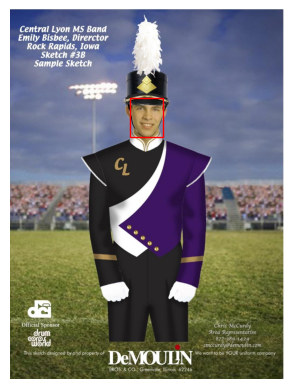

In [13]:
# 이미지 출력
plt.imshow(image)
ax = plt.gca()

# 각 얼굴의 바운딩 박스를 이미지 위에 표시
for face_info in faces['bbox']:
    x, y, w, h = face_info
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.axis('off')
plt.show()

In [14]:
from datasets import Dataset, DatasetDict, Features, Array2D, Sequence, Value, Image
from PIL import Image as PILImage
import numpy as np
import cv2

# Features 정의
features = Features({
    'image': Image(),  # 이미지 저장을 위한 Image 기능 사용
    'faces': Sequence({
        'bbox': Array2D(dtype="float32", shape=(None, 4)),
        'blur': Value(dtype="int64"),
        'expression': Value(dtype="int64"),
        'illumination': Value(dtype="int64"),
        'occlusion': Value(dtype="int64"),
        'pose': Value(dtype="int64"),
        'invalid': Value(dtype="bool"),
    })
})

# 빈 데이터셋 생성
train_mosaicking = Dataset.from_dict({
    'image': [],
    'faces': []
}, features=features)

print(train_mosaicking)

Dataset({
    features: ['image', 'faces'],
    num_rows: 0
})


In [15]:
# 이미지를 읽고 얼굴 검출 후 모자이크를 적용하는 함수
def apply_mosaic(image, faces):
    # 이미지를 넘파이 배열로 변환
    image_cv2 = np.array(image)

    # 얼굴 주위에 모자이크를 적용하는 함수
    def apply_mosaic_to_face(face):
        x, y, w, h = face
        # 얼굴 부분 모자이크를 적용하기 위해 해당 영역 추출
        face_roi = image_cv2[int(y):int(y+h), int(x):int(x+w)]
        if face_roi.shape[0] > 0 and face_roi.shape[1] > 0:
            # 모자이크 적용
            face_roi = cv2.resize(face_roi, (max(1, int(w//15)), max(1, int(h//15))))
            face_roi = cv2.resize(face_roi, (int(w), int(h)), interpolation=cv2.INTER_NEAREST)
            # 모자이크가 적용된 영역 다시 원본 이미지에 삽입
            image_cv2[int(y):int(y+h), int(x):int(x+w)] = face_roi
        return image_cv2

    # 각 얼굴에 모자이크를 적용
    for face in faces['bbox']:
        image_cv2 = apply_mosaic_to_face(face)

    # 넘파이 배열을 PIL 이미지로 변환하여 반환
    return PILImage.fromarray(image_cv2)

## train 데이터셋 모자이크 처리

In [16]:
from datasets import Dataset, DatasetDict, Features, Array2D, Sequence, Value, Image
from PIL import Image as PILImage
import numpy as np
import cv2

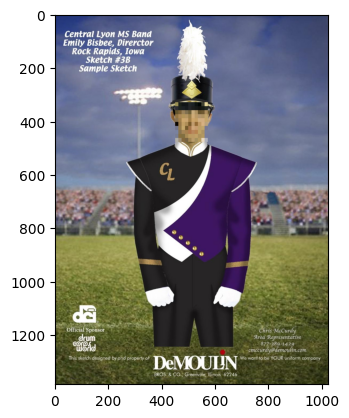

In [17]:
def mosaic_area(image, bbox, mosaic_size=10):
    x, y, w, h = map(int, bbox)
    region = image.crop((x, y, x + w, y + h))
    region = region.resize((mosaic_size, mosaic_size), PILImage.NEAREST).resize((w, h), PILImage.NEAREST)
    image.paste(region, (x, y, x + w, y + h))
    return image

# 첫 번째 이미지만 가져오기
first_image = train_dataset[0]['image']
first_image_faces = train_dataset[0]['faces']

# 이미지 열기 (이미 열려있는 이미지 객체이므로 PILImage.open() 호출 제거)
# image = PILImage.open(first_image).convert("RGB")
image = first_image.convert("RGB")

# 첫 번째 이미지에만 얼굴 정보를 사용하여 모자이크 처리
for bbox in first_image_faces['bbox']:
    image = mosaic_area(image, bbox)

# 모자이크 처리된 이미지 출력
plt.imshow(image)
ax = plt.gca()

In [18]:
# 새로운 dataset 생성
mosaicked_images = []

# train_dataset에 있는 각 이미지에 대해 모자이크 처리를 적용
for data in train_dataset:
    image = data['image'].convert("RGB")
    faces = data['faces']

    # 얼굴 정보를 사용하여 모자이크 처리
    for bbox in faces['bbox']:
        image = mosaic_area(image, bbox)

    # 모자이크 처리된 이미지를 리스트에 추가
    mosaicked_images.append(image)

# 모자이크 처리된 이미지를 train_mosaicking dataset으로 변환
train_mosaicking = Dataset.from_dict({'image': mosaicked_images})

# 결과 확인
print(train_mosaicking)

Dataset({
    features: ['image'],
    num_rows: 1000
})


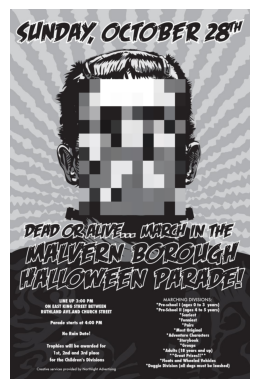

In [19]:
# 첫 번째 이미지 가져오기
first_mosaicked_image = train_mosaicking['image'][34]

# 이미지 출력
plt.imshow(first_mosaicked_image)
plt.axis('off')
plt.show()

## Autoencoder 설정

In [20]:
train_dataset

Dataset({
    features: ['image', 'faces'],
    num_rows: 1000
})

In [21]:
train_mosaicking

Dataset({
    features: ['image'],
    num_rows: 1000
})

In [22]:
import numpy as np

# Define SIZE before it is used
SIZE = 160  # 이미지 크기

# train_dataset에서 이미지 추출
train_images_list = [np.array(example['image'].resize((SIZE, SIZE))) for example in train_dataset] # Resize images to a consistent size
train_images = np.array(train_images_list)

# train_mosaicking에서 이미지 추출
mosaicked_images_list = [np.array(example.resize((SIZE, SIZE))) for example in train_mosaicking['image']] # Resize images to a consistent size
mosaicked_images = np.array(mosaicked_images_list)

# Use the select method to get specific parts of the dataset
train_images_subset = train_dataset.shuffle(seed=42).select(range(900))['image']
test_images_subset = train_dataset.shuffle(seed=42).select(range(900,1000))['image']

mosaicked_images_subset = train_mosaicking.shuffle(seed=42).select(range(900))['image']
test_mosaicked_images_subset = train_mosaicking.shuffle(seed=42).select(range(900,1000))['image']

# Convert PIL images to NumPy arrays with consistent shape
def process_images(image_list):
    processed_images = []
    for img in image_list:
        img_array = np.array(img.resize((SIZE, SIZE)))  # Resize and convert to NumPy array
        processed_images.append(img_array)
    return np.array(processed_images)

# Process the image subsets
train_images = process_images(train_images_subset)
test_images = process_images(test_images_subset)
mosaicked_images = process_images(mosaicked_images_subset)
test_mosaicked_images = process_images(test_mosaicked_images_subset)


# 결과 출력
print('학습 세트:')
print('train_images shape:', train_images.shape)
print('mosaicked_images shape:', mosaicked_images.shape)
print('\n테스트 세트:')
print('test_images shape:', test_images.shape)
print('test_mosaicked_images shape:', test_mosaicked_images.shape)

학습 세트:
train_images shape: (900, 160, 160, 3)
mosaicked_images shape: (900, 160, 160, 3)

테스트 세트:
test_images shape: (100, 160, 160, 3)
test_mosaicked_images shape: (100, 160, 160, 3)


In [23]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [24]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)

    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [25]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 80, 80, 128)          3584      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 40, 40, 128)          147584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 20, 20, 256)          296192    ['sequential_1[0][0]']        
                                                                                              

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

# Replace 'train_g' and 'train_c' with the correct variable names for your training data
model.fit(train_images, mosaicked_images, epochs = 50,batch_size = 50,verbose = 0) # Assuming 'train_images' and 'mosaicked_images' are your training data

In [ ]:
model.evaluate(test_images,test_mosaicked_images)

ValueError: Expected input data to be non-empty.

In [ ]:
# defining function to plot images pair
def plot_images(original,mosaic,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Original Image', color = 'green', fontsize = 20)
    plt.imshow(orginal)
    plt.subplot(1,3,2)
    plt.title('Mosaic Image ', color = 'black', fontsize = 20)
    plt.imshow(mosaic)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_images[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_images[i],test_mosaicked_images[i],predicted)
